# Feature engineering

In [8]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('../data/all_data.csv')

De volgende measurements hebben we van *alle* transportation modes:

In [9]:
# Columns with values for every label (transportation mode) 
usable_cols = ['Latitude (°)','Longitude (°)','Horizontal Accuracy (m)','Acceleration x (m/s^2)','Acceleration y (m/s^2)','Acceleration z (m/s^2)','Gyroscope x (rad/s)','Gyroscope y (rad/s)','Gyroscope z (rad/s)']



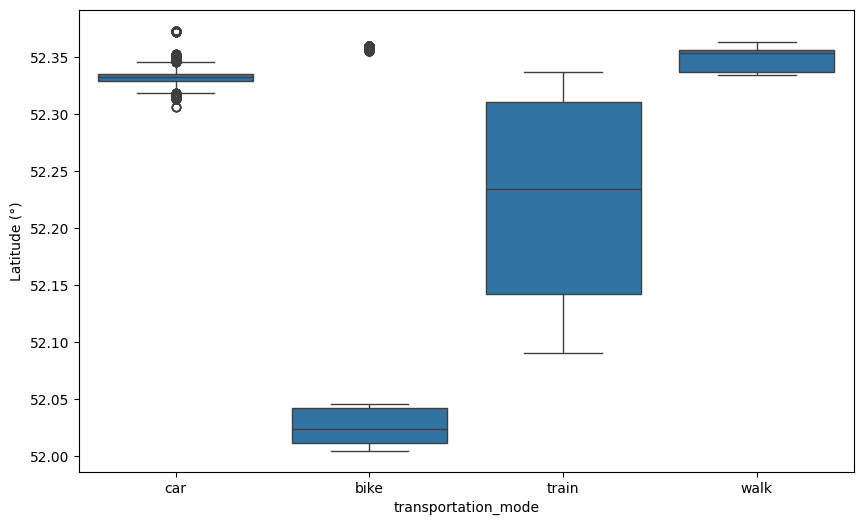

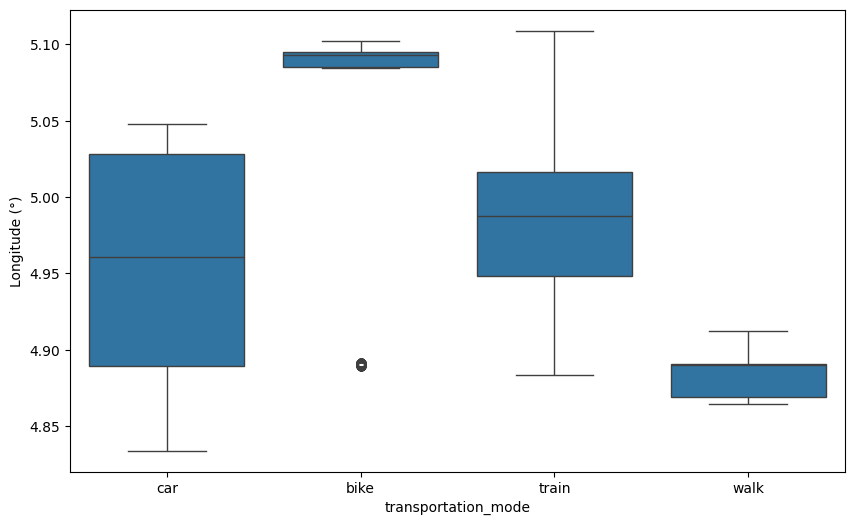

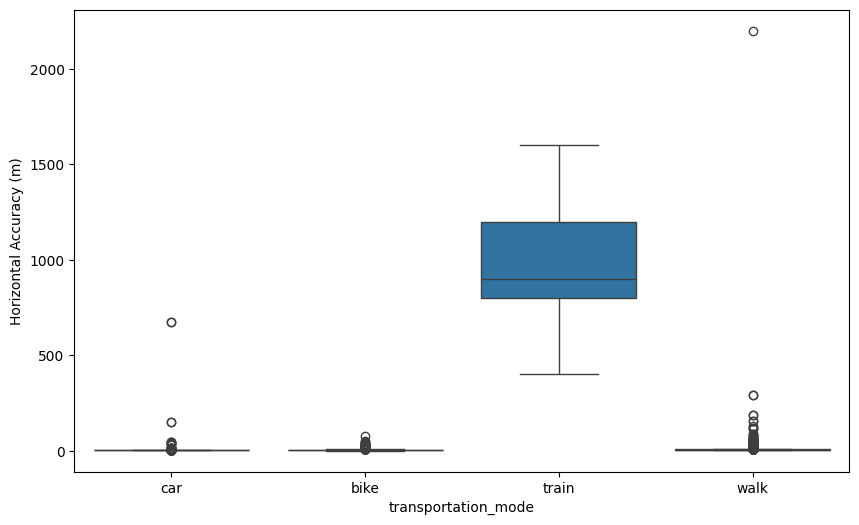

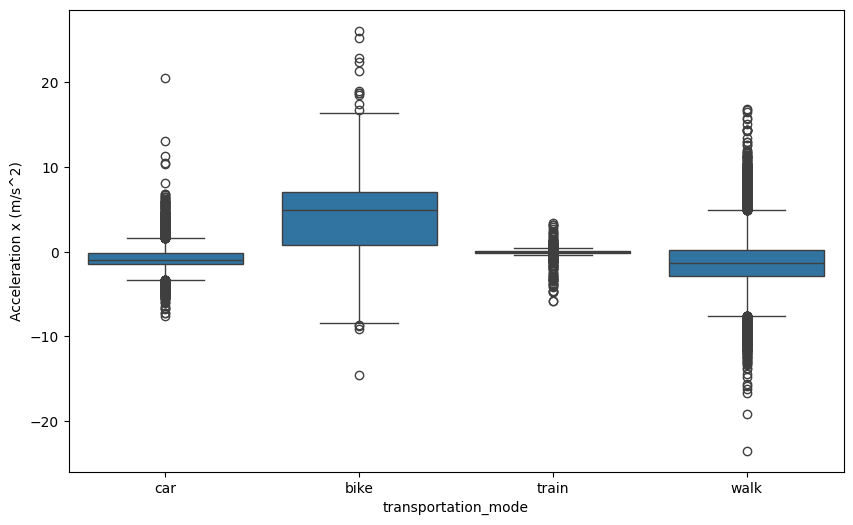

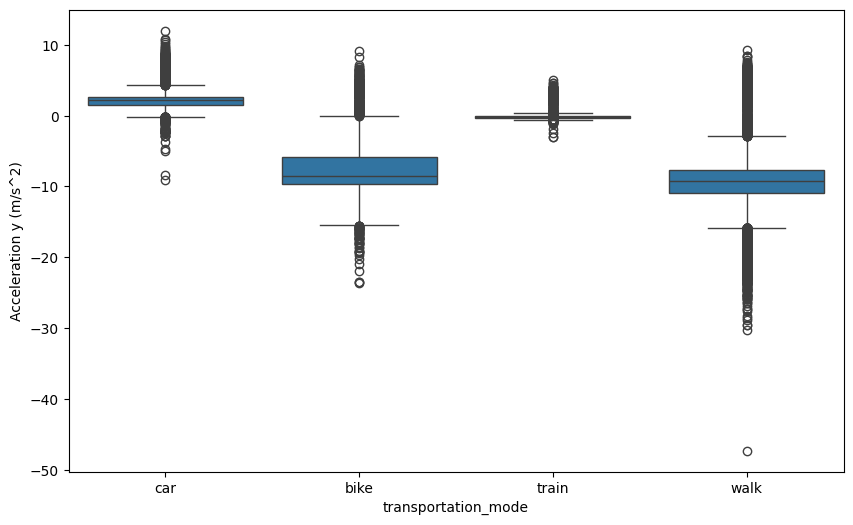

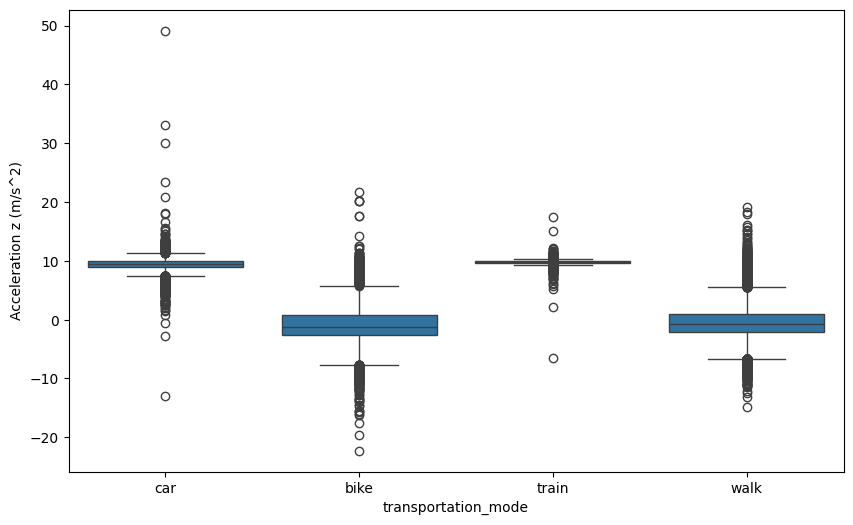

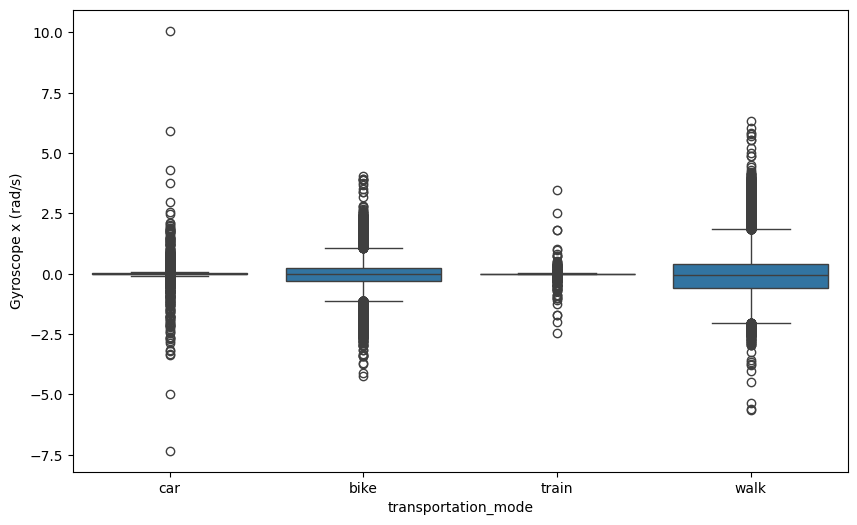

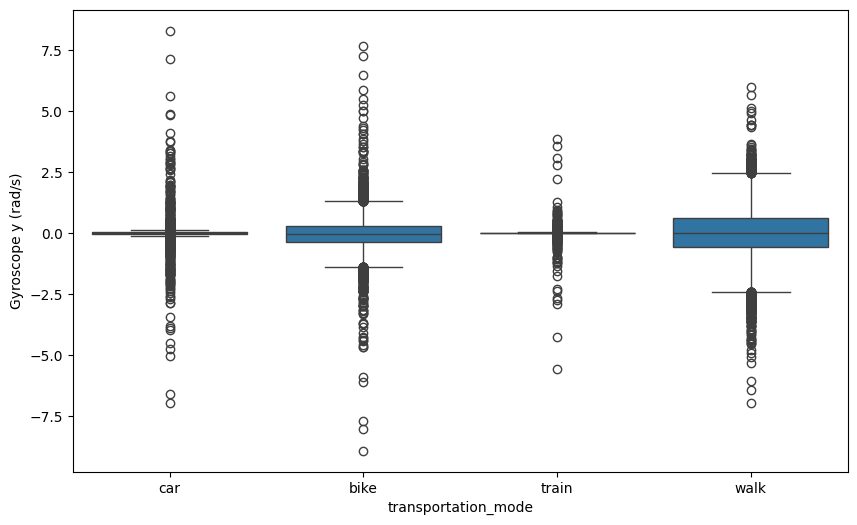

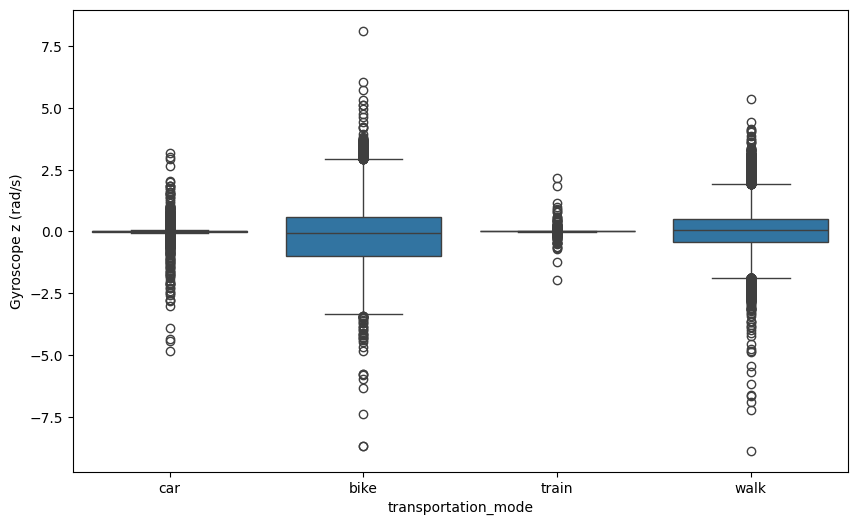

In [10]:
# Create some graphs of the measurement data per transportation_mode
import matplotlib.pyplot as plt
import seaborn as sns

for measurement in usable_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(y=measurement, x='transportation_mode', data=data)
    plt.show()


# Create new feature total accelleration

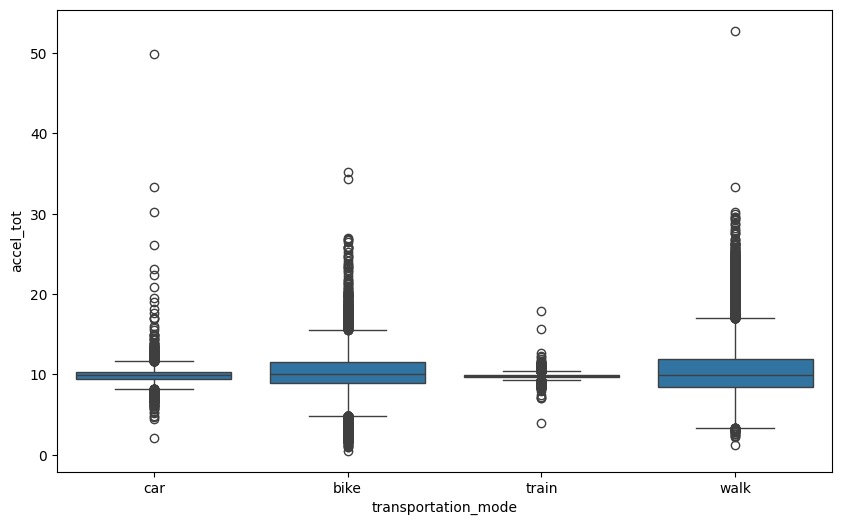

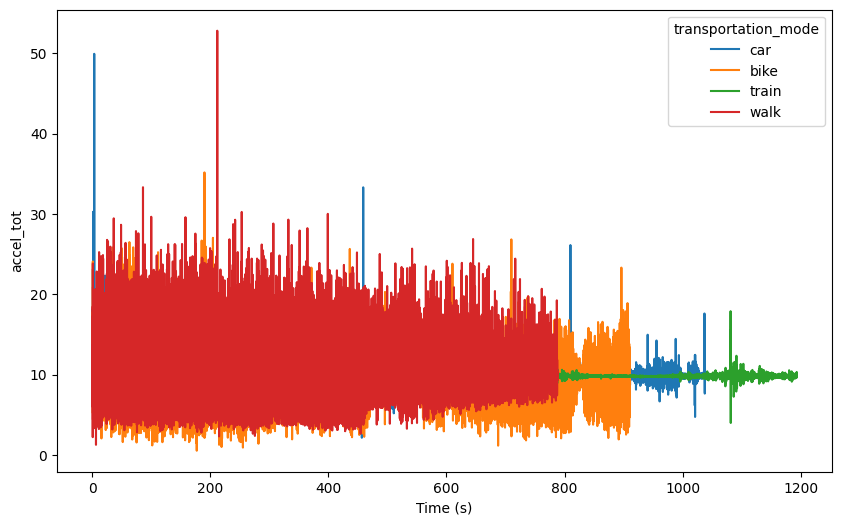

In [15]:
data['accel_tot'] = np.sqrt(np.square(data['Acceleration x (m/s^2)']) + np.square(data['Acceleration y (m/s^2)']) + np.square(data['Acceleration z (m/s^2)']))

plt.figure(figsize=(10,6))
sns.boxplot(y='accel_tot', x='transportation_mode', data=data)
plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(y='accel_tot', x='Time (s)', hue='transportation_mode', data=data)
plt.show()

# plt.figure(figsize=(10,6))
# sns.lineplot(y='Acceleration x (m/s^2)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()

# plt.figure(figsize=(10,6))
# sns.lineplot(y='Acceleration y (m/s^2)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()


# plt.figure(figsize=(10,6))
# sns.lineplot(y='Acceleration z (m/s^2)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()

Aan deze figuren te zien twijfel ik of we hier iets mee kunnen. Wat opvalt: 
* Walk/bike hebben grotere *variance* in acceleration, hier kunnen we misschien iets mee (maar vind het raar, zou het andersom verwachten)
* de mean acceleration is hetzelfde (wat ik ook raar vind), hier kunnen we dus niets mee

# Variance of acceleration

In [16]:
lamb = 150
data['accel_var'] = data['accel_tot'].rolling(window=lamb).var()
mean_by_category = data.groupby('transportation_mode')['accel_var'].mean()
print(mean_by_category)

transportation_mode
bike     7.422550
car      0.816743
train    0.111350
walk     9.361090
Name: accel_var, dtype: float64


Dus bike/walk hebben duidelijk grotere variance van acceleration

# Create feature displacement (delta x)

In [27]:
from geopy.distance import geodesic
from math import isnan

lamb = 150

# Calculate Delta s: distance between coordinates and over 15 seconds
def calculate_delta_s(row):
    if row.name <= lamb:
        return float('nan')

        
    else:
        x1 = (data.loc[row.name - lamb, 'Latitude (°)'], data.loc[row.name - lamb, 'Longitude (°)'])
        x2 = (row['Latitude (°)'], row['Longitude (°)'])
        if isnan(x1[0]) or isnan(x1[1]) or isnan(x2[0]) or isnan(x2[1]):
            # om een of andere reden wordt hier alle 'train' data geskipped :(
            return float('nan')
    
    return geodesic(x1, x2).meters

data['Delta x'] = data.apply(lambda x: calculate_delta_s(x), axis=1)


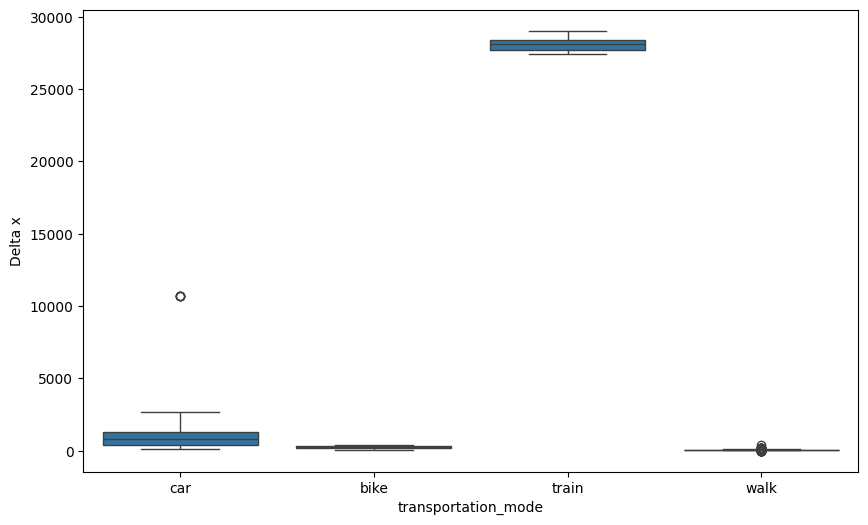

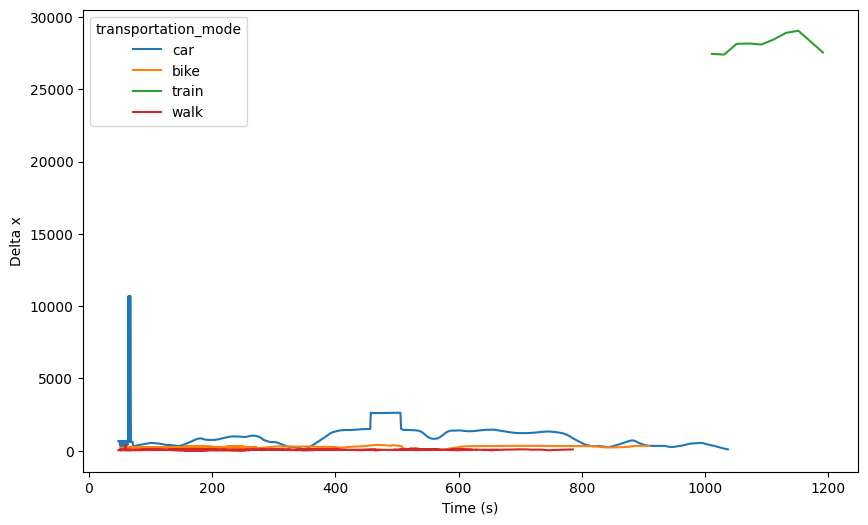

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Delta x', x='transportation_mode', data=data)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='Delta x', x='Time (s)', hue='transportation_mode', data=data)
plt.show()


# Create feature Velocity

In [ ]:
# Calculate velocity
data['Velocity_new (m/s)'] = data['Delta s'] / lamb

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Velocity_new (m/s)', x='transportation_mode', data=data)
plt.show()

# plt.figure(figsize=(10,6))
# sns.boxplot(y='Velocity (m/s)', x='transportation_mode', data=data)
# plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(y='Velocity_new (m/s)', x='Time (s)', hue='transportation_mode', data=data)
plt.show()

# plt.figure(figsize=(10,6))
# sns.lineplot(y='Velocity (m/s)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()

ValueError: Could not interpret value `Velocity_new (m/s)` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

Om de een of andere reden houden we geen displacement (en dus geen velocity) over voor 'train' data, ik snap niet waarom. De grafieken hieronder (nu uit-gecomment) suggereren dat er wel voldoende latitude/longitude info van 'train' moet zijn

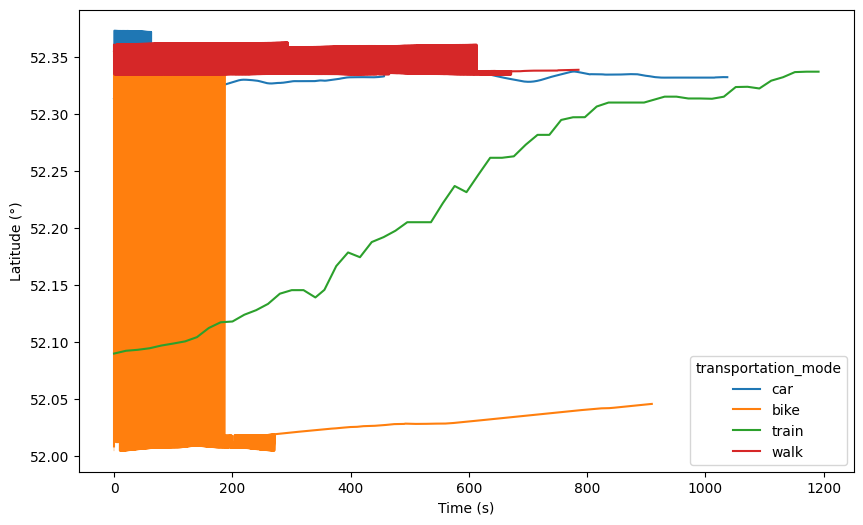

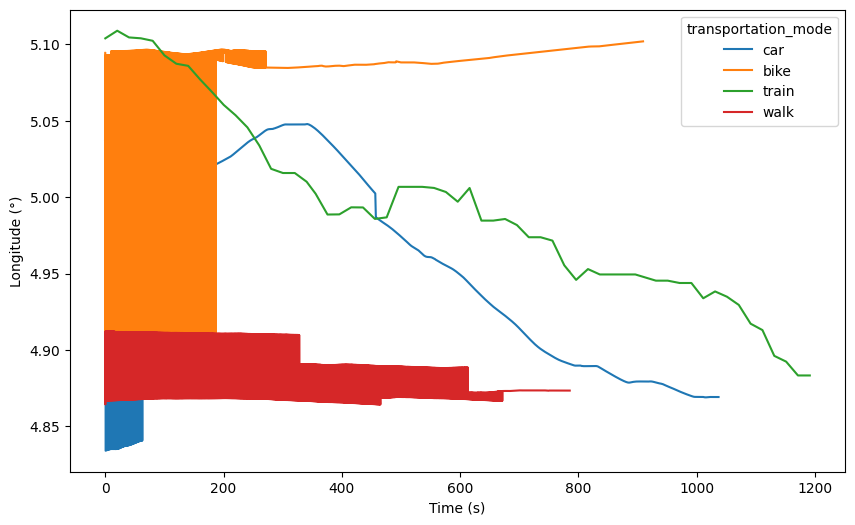

In [6]:
plt.figure(figsize=(10,6))
sns.lineplot(y='Latitude (°)', x='Time (s)', hue='transportation_mode', data=data)
# plt.savefig(f'{measurement}.png')
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='Longitude (°)', x='Time (s)', hue='transportation_mode', data=data)
# plt.savefig(f'{measurement}.png')
plt.show()

# Create feature jerk


In [7]:


data['Jerk'] = abs(data['accel_tot'].diff() / 0.1).rolling(window=150).mean()

plt.figure(figsize=(10,6))
sns.boxplot(y='Jerk averaged', x='transportation_mode', data=data)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='Jerk averaged', x='Time (s)', hue='transportation_mode', data=data)
plt.show()


KeyError: 'accel_tot'